In [1]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import numpy as np
from scipy import interpolate

from skimage import io
bkImage = io.imread('http://www.solarspace.co.uk/PlanetPics/Neptune/NeptuneAlt1.jpg')
Nx = 20
Ny = 20
dragRadius = 10
hexagonalOffset = 0
pointMarkerSize = 10

%matplotlib notebook

def barycentric_trapezoidial_interpolation(Nx,Ny,p,hexagonalOffset=0.5):
    x_basis = np.linspace(0,1,Nx)
    y_basis = np.linspace(0,1,Ny)
        
    px = [[p[0,0], p[2,0]],[p[1,0], p[3,0]]] #these are the [2,2] x-coordinates
    py = [[p[0,1], p[2,1]],[p[1,1], p[3,1]]] #these are the [2,2] x-coordinates
    #fx = interpolate.interp2d([1,0], [1,0], px, kind='linear')
    fx = interpolate.interp2d([0,1], [0,1], px, kind='linear')
    xi = fx(x_basis[:],y_basis[:]).flatten()
    #fy = interpolate.interp2d([1,0], [1,0], py, kind='linear')
    fy = interpolate.interp2d([0,1], [0,1], py, kind='linear')
    yi = fy(x_basis[:],y_basis[:]).flatten()
    d1 = (p[2,0] - p[0,0]) / Nx / 2.0
    d2 = (p[3,0] - p[1,0]) / Nx / 2.0
    offset = (d1 + d2) * hexagonalOffset
    #every other row will be shifted in diff(x) * hexagonalOffset
    for i in range(0,len(xi)-Nx,Nx*2):
        for j in range(Nx):
            xi[i+j+Nx] += offset
    return xi,yi


In [2]:
class DraggablePoint:
    lock = None #only one can be animated at a time
    
    def __init__(self, point,h1,ax, Nx, Ny,annotation,hexagonalOffset):
        self.point = point
        self.press = None
        self.background = None
        self.h1 = h1
        self.ax = ax
        self.Nx = Nx
        self.Ny = Ny
        self.annotation=annotation
        self.hexagonalOffset = hexagonalOffset
        

    def connect(self):
        'connect to all the events we need'
        self.cidpress = self.point.figure.canvas.mpl_connect('button_press_event', self.on_press)
        self.cidrelease = self.point.figure.canvas.mpl_connect('button_release_event', self.on_release)
        self.cidmotion = self.point.figure.canvas.mpl_connect('motion_notify_event', self.on_motion)

    def on_press(self, event):
        if event.inaxes != self.point.axes: return
        if DraggablePoint.lock is not None: return
        contains, attrd = self.point.contains(event)
        if not contains: return
        self.press = (self.point.center), event.xdata, event.ydata
        DraggablePoint.lock = self

        # draw everything but the selected rectangle and store the pixel buffer
        canvas = self.point.figure.canvas
        axes = self.point.axes
        self.point.set_animated(True)
        canvas.draw()
        self.background = canvas.copy_from_bbox(self.point.axes.bbox)

        # now redraw just the rectangle
        axes.draw_artist(self.point)

        # and blit just the redrawn area
        canvas.blit(axes.bbox)

    def on_motion(self, event):
        if DraggablePoint.lock is not self:
            return
        if event.inaxes != self.point.axes: return
        self.point.center, xpress, ypress = self.press
        dx = event.xdata - xpress
        dy = event.ydata - ypress
        self.point.center = (self.point.center[0]+dx, self.point.center[1]+dy)
        self.annotation.set_position(self.point.center)
        
        canvas = self.point.figure.canvas
        axes = self.point.axes
        
        # restore the background region
        canvas.restore_region(self.background)

        # redraw just the current rectangle
        axes.draw_artist(self.point)
#         axes.set_title(str(self.point.center))
        # blit just the redrawn area
        canvas.blit(axes.bbox)
        
        p = []
        for d in self.ax.patches:
            p.append(d.center)
        p = np.asarray(p)
        
        xi,yi = barycentric_trapezoidial_interpolation(self.Nx,self.Ny,p,hexagonalOffset = self.hexagonalOffset)

        self.h1.set_xdata(xi)
        self.h1.set_ydata(yi)

        #self.point.figure.canvas.draw()
        
    def on_release(self, event):
        'on release we reset the press data'
        if DraggablePoint.lock is not self:
            return

        self.press = None
        DraggablePoint.lock = None

        # turn off the rect animation property and reset the background
        self.point.set_animated(False)
        self.background = None

        # redraw the full figure
        self.point.figure.canvas.draw()

    def disconnect(self):
        'disconnect all the stored connection ids'
        self.point.figure.canvas.mpl_disconnect(self.cidpress)
        self.point.figure.canvas.mpl_disconnect(self.cidrelease)
        self.point.figure.canvas.mpl_disconnect(self.cidmotion)

<IPython.core.display.Javascript object>


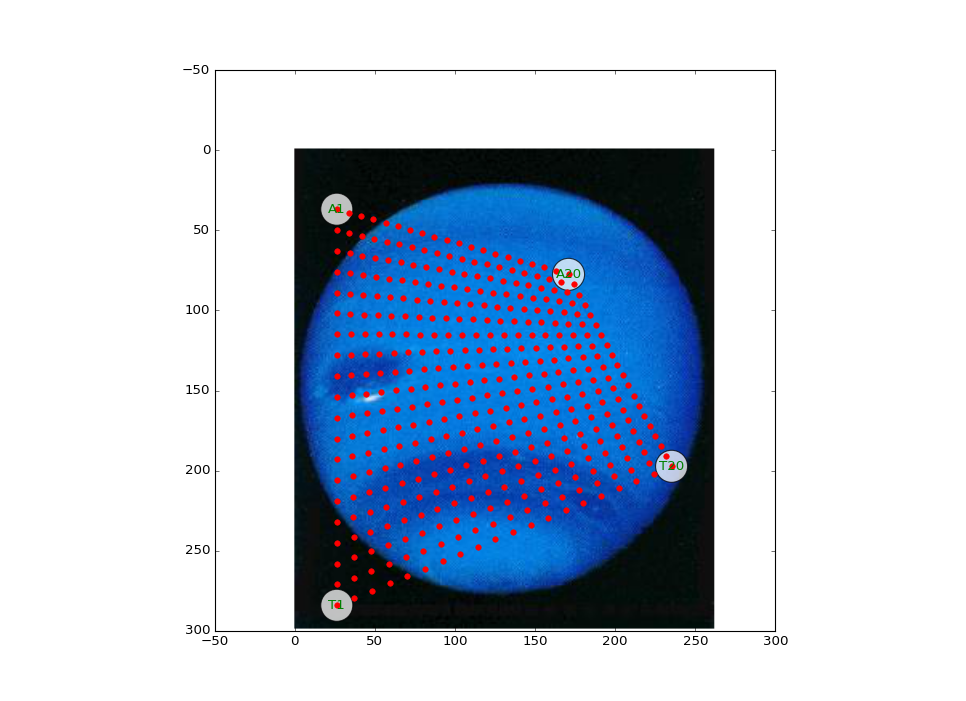

In [3]:




fig = plt.figure()
fig.set_facecolor('white')
ax = fig.add_subplot(111)
ax.imshow(bkImage)
ax.set_aspect('equal')

circles = []
circles.append(patches.Circle((0,0), dragRadius, fc='white', alpha=0.75, ))
circles.append(patches.Circle((0,bkImage.shape[0]), dragRadius, fc='white', alpha=0.75, ))
circles.append(patches.Circle((bkImage.shape[1],0), dragRadius, fc='white', alpha=0.75, ))
circles.append(patches.Circle((bkImage.shape[1],bkImage.shape[0]), dragRadius, fc='white', alpha=0.75, ))


rowAlpha=chr(ord('A')+Ny-1)
annontations = [plt.annotate("A1",(0,0),color="green",horizontalalignment='center', verticalalignment='center'),
                plt.annotate("".join([rowAlpha,"1"]),(0,bkImage.shape[0]),color="green",horizontalalignment='center', verticalalignment='center'),
                plt.annotate("".join(["A",str(Nx)]),(bkImage.shape[1],0),color="green",horizontalalignment='center', verticalalignment='center'),
                plt.annotate("".join([rowAlpha,str(Nx)]),(bkImage.shape[1],bkImage.shape[0]),color="green",horizontalalignment='center', verticalalignment='center')]


p = []
for d in circles:
    p.append(d.center)
p = np.asarray(p)
xi,yi = barycentric_trapezoidial_interpolation(Nx,Ny,p,hexagonalOffset=hexagonalOffset)

h1, = ax.plot(xi,yi,'r.',markersize=pointMarkerSize)

drs = []
for c,circ in enumerate(circles):
    ax.add_patch(circ)
#     dr = DraggablePointForBarycentricInterpolation(circ,h1,ax, Nx, Ny,annontations[c],hexagonalOffset)
    dr = DraggablePoint(circ,h1,ax, Nx, Ny,annontations[c],hexagonalOffset)
    dr.connect()
    drs.append(dr)

plt.show()
